In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet

from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

import cv2
from skimage.transform import resize
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops, regionprops_table
from scipy.ndimage import binary_fill_holes

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
# upload train dataframe
path = "../../data-512/"
train_df_allsamples = pd.read_csv(path+"train.csv")
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [4]:
# upload test dataframe
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


In [252]:
# color constancy (function originally designed by https://github.com/JiaxinZhuang/Skin-Lesion-Recognition.Pytorch)
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    h, w, c = img.shape
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((h,1), dtype='uint8') * 0
        for i in range(h):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)


def im_filter(img, thresh):
    
    # grayscale and blur img 
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = gaussian(img_gray, 3)
    
    # determine binarization level 
    lvl = thresh*threshold_otsu(img_blur) 
    
    # binarize image 
    img_bin = np.ones(img_gray.shape)
    img_bin[img_blur > lvl] = 0
    img_filled = binary_fill_holes(img_bin)
    return label(img_filled)

# function to crop image 
def crop(img, imsize=256, margin=.5, min_ratio=.2, thresh=.7):
    # use shade of grey 
    img = shade_of_gray_cc(img)
    
    label_img = im_filter(img, thresh)
    [n, m] = label_img.shape
    stats = regionprops(label_img)
    
    # get diamter and center of im
    if len(stats) > 0:
        axis_lengths = []
        centroids = []
        for stat in stats:
            axis_lengths.append(np.atleast_2d([stat.minor_axis_length, stat.major_axis_length]))
            centroids.append(np.atleast_2d(stat.centroid))
        diameters = np.mean(np.concatenate(axis_lengths, axis=0), 1)
        centroids = np.concatenate(centroids, axis=0)
    else:
        # give up
        img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
        return img_resize, label_img
    
    inds = np.argsort(diameters)[::-1]
    radius = diameters[inds[0]] / 2 
    center = centroids[inds[0], :]
    
    x_min = np.int(center[0]-radius-margin*radius)
    x_max = np.int(center[0]+radius+margin*radius)
    y_min = np.int(center[1]-radius-margin*radius)
    y_max = np.int(center[1]+radius+margin*radius)
    
    if x_min < 0 or x_max > n or y_min < 0 or y_max > m:
        if len(inds) > 1:
            # use second largest diameter 
            radius = diameters[inds[1]] / 2 
            center = centroids[inds[1], :]

            x_min = np.int(center[0]-radius-margin*radius)
            x_max = np.int(center[0]+radius+margin*radius)
            y_min = np.int(center[1]-radius-margin*radius)
            y_max = np.int(center[1]+radius+margin*radius)

            if x_min < 0 or x_max > n or y_min < 0 or y_max > m:
                # give up
                img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
                return img_resize, label_img
        else:
            # give up
            img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
            return img_resize, label_img
        
    # make sure crop isn't too small 
    min_size = min_ratio*np.min([n, m])
    if (x_max - x_min) < min_size or (y_max - y_min) < min_size: 
        img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
        return img_resize, label_img      
        
    # look at ratio of pixel intensity inside and outside of cropped image 
    mean_inside = np.mean(img[x_min:x_max, y_min:y_max, :]) 
    mean = np.mean(img)
    
    print(mean_inside)
    print(mean)
    if mean_inside > mean: # lower actually better, since dark pixels --> 0, want dark pixels 
        # give up
        img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
        return img_resize, label_img
    
    # crop and resize image 
    try:
        img_cropped = img[x_min:x_max, y_min:y_max, :]
        img_resize = cv2.resize(img_cropped, (imsize, imsize), interpolation = cv2.INTER_CUBIC)
    except:
        img_resize = cv2.resize(img, (imsize, imsize), interpolation = cv2.INTER_AREA)
        return img_resize, label_img
    
    return img_resize, label_img

In [189]:
# create dict for test images
path_dict = {}
test_names = test_df.image_name.values
for img_name in test_names:
    path_dict[img_name] = "../../data-512/test/"

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=15, fill=255),
    transforms.ToTensor()])

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_dict):
        # 1. Initialize file paths or a list of file names.
        self.path_dict = path_dict
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).

        # load X
        img_name = self.df['image_name'].values[index]
        img_path = self.path_dict[img_name] + img_name + ".jpg"
        img = plt.imread(img_path)

        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_cropped = crop(img)
        img_processed = transform_valid(img_cropped)
        # 3. Return a data pair (e.g. image and label).
        return img_processed 

    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [7]:
# First, load the EfficientNet with pre-trained parameters 

class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=1024)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.LeakyReLU(),
                                    nn.Linear(1024, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

In [8]:
# path to test images 
test_path = path + "test/"

# define batch size and accumulation steps 
batchsize  = 12

# store predictions 
predictions = np.zeros(len(test_df))

# define n_folds
n_folds = 1

# loop through each fold model 
for i in np.arange(1, n_folds+1):
    print("fold {}".format(i))
    
    # load model 
    ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)
    model = MyENet(ENet).to(device)
    model.load_state_dict(torch.load('../Models/model_{}.ckpt'.format(i)))
    model.eval()
    
    # make predictions on test data
    test_dataset = TestDataset(test_df, path_dict)                                              
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)

    fold_pred = []
    for images in test_loader:
        # Forward pass
        images = images.to(device)
        fold_pred.append(model(images).detach().cpu().numpy())
    fold_pred = np.concatenate(fold_pred, axis=0).ravel()
    
    # store predictions
    predictions += fold_pred / n_folds

fold 1
Loaded pretrained weights for efficientnet-b0


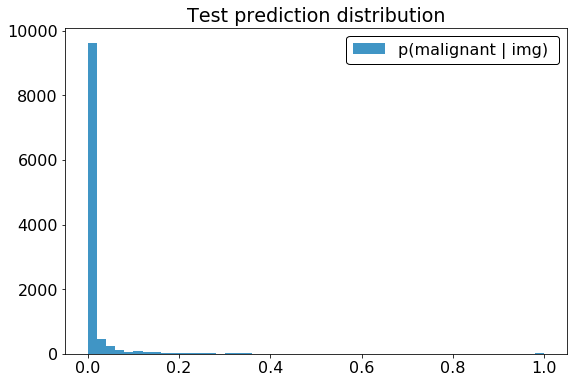

In [9]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

counts, bins = np.histogram(predictions, bins=50)
plt.hist(predictions, bins=bins, label='p(malignant | img) ', alpha=.75)

plt.legend()
plt.title("Test prediction distribution")
plt.show()

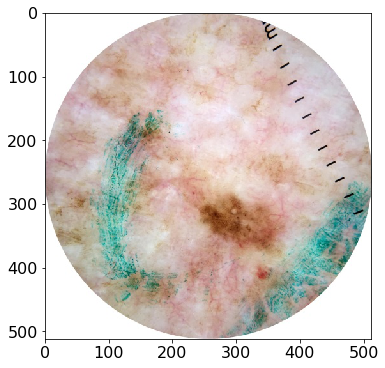

In [292]:
index = np.argsort(predictions)[-25]

img_name = test_df['image_name'].values[index]
img_path = path_dict[img_name] + img_name + ".jpg"
img = plt.imread(img_path)

plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.show()

156.18796670630203
194.60286966959634


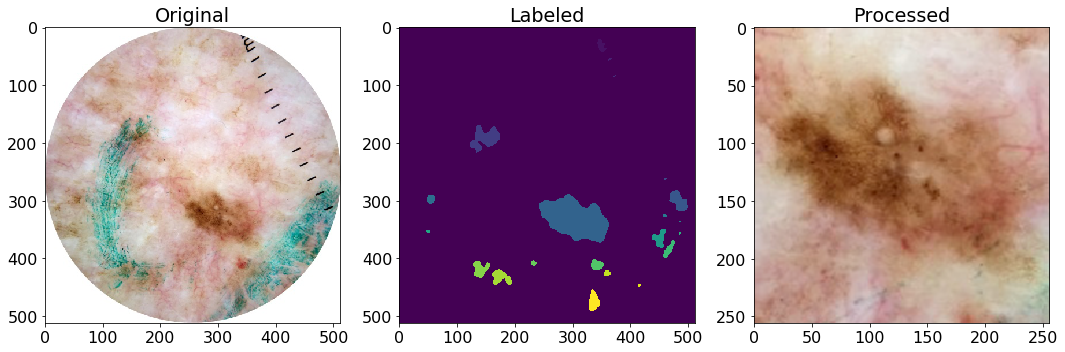

In [293]:
img_crop, label_img = crop(img, thresh=.64)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(label_img)
plt.title("Labeled")

plt.subplot(1, 3, 3)
plt.imshow(img_crop)
plt.title("Processed")

plt.show()

In [10]:
submission = pd.DataFrame()

image_names = test_df['image_name'].values
submission["image_name"] = image_names 
submission["target"] = predictions
submission.head()

,image_name,target
0,ISIC_0052060,0.000008
1,ISIC_0052349,0.000004
2,ISIC_0058510,0.000032
3,ISIC_0073313,0.000002
4,ISIC_0073502,0.000661


In [11]:
submission.to_csv("Submission.csv", index=False)